In [135]:
# load libaries
import os
import SimpleITK as sitk
from skimage.transform import radon, iradon
from scipy.ndimage import gaussian_filter
import numpy as np

import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse

import torch
import torch.nn as nn
from torch.optim import Adam
from scipy.ndimage import rotate

import cv2
from skimage.restoration import denoise_tv_chambolle

#Import the DIP repository, make sure to clone https://github.com/DmitryUlyanov/deep-image-prior
import sys
sys.path.append('C:/Users/ester/deep-image-prior')
from models import skip

In [136]:
def generate_sinogram_2d(image_2d, angles):
    # Get image dimensions
    rows, cols = image_2d.shape
    # Calculate the radius of the circle
    radius = min(rows, cols) // 2
    # Create a mask to zero out areas outside the circle
    Y, X = np.ogrid[:rows, :cols]
    center_y, center_x = rows / 2, cols / 2
    mask = (X - center_x)**2 + (Y - center_y)**2 <= radius**2
    image_masked = image_2d * mask
    # Generate sinogram
    sinogram = radon(image_masked, theta=angles, circle=True)
    return sinogram

def add_poisson_noise(sinogram, scale=1e4):
    # Ensure there are no negative values (Poisson noise requires non-negative input)
    sinogram_clipped = np.clip(sinogram, 0, None)
    
    # Scale up the intensity values to approximate "photon counts"
    sinogram_scaled = sinogram_clipped * scale
    
    # Generate Poisson noise (random photon counts)
    sinogram_noisy_scaled = np.random.poisson(sinogram_scaled).astype(np.float32)
    
    # Scale back down to the original magnitude
    sinogram_noisy = sinogram_noisy_scaled / scale
    return sinogram_noisy

def backproject(sinogram, angles):
    reconstructed = np.zeros((sinogram.shape[1], sinogram.shape[1]))
    for i, angle in enumerate(angles):
        rotated_projection = rotate(np.tile(sinogram[i], (sinogram.shape[1], 1)).T, -angle, reshape=False)
        reconstructed += rotated_projection
    return reconstructed / len(angles)

def generate_sinogram(image, num_angles=180):
    angles = np.linspace(0, 180, num_angles, endpoint=False)
    sinogram = np.array([np.sum(rotate(image, angle, reshape=False), axis=0) for angle in angles])
    return sinogram, angles

In [137]:
def MLEM_reconstruction(sinogram, angles, reference_image, num_iterations=50):
    image_shape = (sinogram.shape[1], sinogram.shape[1])
    reconstructed = np.ones(image_shape, dtype=np.float32)
    psnr_values = []
    epsilon = 1e-6

    reference_image = cv2.resize(reference_image, (image_shape[1], image_shape[0]))

    for iteration in range(num_iterations):
        forward_projection = radon(reconstructed, theta=angles, circle=True)

        if forward_projection.shape != sinogram.shape:
            forward_projection = forward_projection[: sinogram.shape[0], :]

        ratio = sinogram / (forward_projection + epsilon)
        back_projection = iradon(ratio, theta=angles, filter_name=None, circle=True)

        reconstructed *= back_projection
        reconstructed = np.maximum(reconstructed, 0)

        psnr_value = cv2.PSNR(reference_image.astype(np.float32), reconstructed.astype(np.float32))
        psnr_values.append(psnr_value)

    return reconstructed, psnr_values  # Moved outside the loop


In [138]:
## Dicom reader
def load_dicom_series(folder_path):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(folder_path)
    if not dicom_names:
        raise ValueError(f"No DICOM files found in {folder_path}")
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    return image

def normalize_image(image):
    img_array = sitk.GetArrayFromImage(image).astype(np.float32)
    img_min = np.min(img_array)
    img_max = np.max(img_array)
    if img_max - img_min < 1e-5:
        return np.zeros_like(img_array)
    else:
        return (img_array - img_min) / (img_max - img_min)

In [139]:
## Image registration
def register_pet_ct(ct_image, pet_image, mode="upsample_PET"):
    # Initialize the registration method
    registration_method = sitk.ImageRegistrationMethod()

    # Set multi-resolution pyramid strategy
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Set registration metric
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)

    # Set transformation type (rigid transformation)
    initial_transform = sitk.CenteredTransformInitializer(
        ct_image,
        pet_image,
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY
    )

    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    # Set optimizer
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0,
                                                      numberOfIterations=100,
                                                      convergenceMinimumValue=1e-6,
                                                      convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Set interpolation method
    registration_method.SetInterpolator(sitk.sitkLinear)

    try:
        final_transform = registration_method.Execute(sitk.Cast(ct_image, sitk.sitkFloat32),
                                                      sitk.Cast(pet_image, sitk.sitkFloat32))
        print("Optimizer Converged:", registration_method.GetOptimizerStopConditionDescription())
        print("Final Metric Value:", registration_method.GetMetricValue())
    except Exception as e:
        print(f"\nRegistration failed: {e}")
        raise e

    resampler = sitk.ResampleImageFilter()
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0)
    resampler.SetTransform(final_transform)

    if mode == "upsample_PET":
        resampler.SetReferenceImage(ct_image)
        pet_resampled = resampler.Execute(pet_image)
        print("Resampling completed.")
        return ct_image, pet_resampled

    elif mode == "downsample_CT":
        resampler.SetReferenceImage(pet_image)
        ct_resampled = resampler.Execute(ct_image)
        print("Resampling completed.")
        return ct_resampled, pet_image

    else:
        raise ValueError("Invalid mode selection, mode should be 'upsample_PET' or 'downsample_CT'")

In [140]:
# Design for Bowsher prior Filter 
def apply_bayesian_filter(image_2d, sigma=1.0, zeta=0.5, rho=0.01, alpha=0.001):
    # Compute the Bayesian kernel (Bowsher-like prior)
    kernel = compute_bowsher_kernel_2d(image_2d, zeta=zeta, rho=rho, alpha=alpha)
    filtered_image = image_2d * kernel
    return filtered_image

def compute_kernel_2d(ct_2d, sigma=1.0):
    # Compute the gradient of the CT image
    gradient_x = gaussian_filter(ct_2d, sigma=sigma, order=1, mode='nearest')
    gradient_y = gaussian_filter(ct_2d, sigma=sigma, order=1, mode='nearest')
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

    # Design a bilateral kernel, assigning lower weights to edges
    kernel = np.exp(- (gradient_magnitude ** 2))
    return kernel

def psi(u, zeta=0.5, rho=0.01):
    return (np.arctan((zeta - u) / rho) / np.pi) + 0.5

def Tq_linear(value):
    return value

def compute_bowsher_kernel_2d(
    ct_image_2d, 
    zeta=0.5, 
    rho=0.01, 
    Tq_func=Tq_linear, 
    epsilon=1e-6,
    alpha = 0.001
):

# Offsets for the 8 neighbors in (dy, dx)
    neighbor_offsets = [
        (-1, -1), (-1, 0), (-1, 1),
        ( 0, -1),          ( 0, 1),
        ( 1, -1), ( 1, 0), ( 1, 1)
    ]
    
    H, W = ct_image_2d.shape
    weights_2d = np.zeros((H, W, len(neighbor_offsets)), dtype=np.float32)

    # Pre-compute Tq for the entire image to avoid repeated calls
    transformed_ct = Tq_func(ct_image_2d)

    # For each pixel, we need M_j = max|Tq(mu_j) - Tq(mu_k)| over neighbors
    M_array = np.zeros((H, W), dtype=np.float32)

    for y in range(H):
        for x in range(W):
            central_val = transformed_ct[y, x]
            diffs = []
            for dy, dx in neighbor_offsets:
                ny, nx = y + dy, x + dx
                if 0 <= ny < H and 0 <= nx < W:
                    neighbor_val = transformed_ct[ny, nx]
                    diffs.append(abs(central_val - neighbor_val))
            if len(diffs) > 0:
                M_array[y, x] = max(diffs)
            else:
                M_array[y, x] = 0.0
    
    # Compute the actual weights for each neighbor
    for y in range(H):
        for x in range(W):
            central_val = transformed_ct[y, x]
            Mj = M_array[y, x]
            
            for n_idx, (dy, dx) in enumerate(neighbor_offsets):
                ny, nx = y + dy, x + dx
                if not (0 <= ny < H and 0 <= nx < W):
                    # Out of bounds, weight = 0
                    weights_2d[y, x, n_idx] = 0.0
                    continue
                
                neighbor_val = transformed_ct[ny, nx]
                Mk = M_array[ny, nx]
                
                denom = (Mj + Mk) / 2.0
                denom = denom if denom > epsilon else epsilon
                
                diff = abs(central_val - neighbor_val)
                u_jk = diff / denom
                
                w_jk = psi(u_jk, zeta=zeta, rho=rho)
                weights_2d[y, x, n_idx] = w_jk

    kernel = np.sum(weights_2d, axis=-1)
    kernel = np.exp(alpha * kernel) 
    return kernel

In [141]:
def project(image, angles):
    return radon(image, theta=angles, circle=True)

def backproject(sinogram, angles):
    if isinstance(sinogram, torch.Tensor):
        sinogram = sinogram.cpu().numpy()
    return iradon(sinogram, theta=angles, circle=True)


def apply_filter(image, method="bilateral", sigma=1.0, zeta=0.5, rho=0.01, alpha=0.001, ct_prior=None):

    image_np = image.detach().cpu().numpy() 

    if method == "bilateral":
        filtered_image = cv2.bilateralFilter(image_np.astype(np.float32), d=9, sigmaColor=sigma*50, sigmaSpace=sigma*50)
    
    elif method == "anisotropic":
        filtered_image = denoise_tv_chambolle(image_np, weight=sigma)
    
    elif method == "gaussian":
        filtered_image = gaussian_filter(image_np, sigma=sigma)
    
    elif method == "bayesian":
        filtered_image = apply_bayesian_filter(image_np, sigma=sigma, zeta=zeta, rho=rho, alpha=alpha)
    
    elif method == "gradient":
        if ct_prior is None:
            raise ValueError("CT prior required for gradient-based kernel filtering.")

        # Precompute the anatomical kernel
        if ct_prior is not None:
            ct_prior_np = ct_prior.squeeze().detach().cpu().numpy()
            kernel = compute_kernel_2d(ct_prior_np, sigma=sigma)


        #ct_prior_np = ct_prior.squeeze().detach().cpu().numpy()
        #kernel = compute_kernel_2d(ct_prior_np, sigma=sigma)  # Compute anatomical gradient kernel
        filtered_image = image_np * kernel  # Weight input image by anatomical kernel

    else:
        raise ValueError("Invalid method. Choose 'bilateral', 'anisotropic', 'gaussian', 'bayesian', or 'gradient'.")

    return torch.tensor(filtered_image, dtype=torch.float32).to(image.device)


def KEM_step(image, sinogram, angles, kernel_size, sigma=1.0, filter_method="bilateral", ct_prior=None, num_em_iterations=5):
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    updated_image = image.clone()  # Ensure iterate on a copy

    for _ in range(num_em_iterations):  # Iterate multiple EM steps
        # Step 1: Forward project
        forward_projection = project(updated_image.squeeze().detach().cpu().numpy(), angles) # radon transformation
        forward_projection = torch.tensor(forward_projection, dtype=torch.float32).to(device)

        # Step 2: Compute ratio
        ratio = sinogram / (forward_projection + 1e-8)
        ratio = ratio.clamp(min=0, max=10)  # Prevent extreme values

        # Step 3: Backproject ratio update
        back_projection = backproject(ratio.cpu().numpy(), angles)
        back_projection = torch.tensor(back_projection, dtype=torch.float32).to(device)

        # Step 4: Apply filtering
        smoothed_image = apply_filter(updated_image.squeeze(), method=filter_method, sigma=sigma, ct_prior=ct_prior)

        # Step 5: Update estimate
        updated_image.mul_(smoothed_image) # same as updated_image = smoothed_image * back_projection but this is better for memory allocation
        #updated_image = updated_image / updated_image.max()  # Normalize

    return updated_image.unsqueeze(0).unsqueeze(0)

In [142]:
# NR1 KEM Implementation 
# use a simple gaussian kernel 

def KEM_model(sinogram, initial_shape, angles, sigma=0.8, num_iterations=100, apply_kernel_every=10): #added , apply_kernel_every=2
    """
    Perform Kinetic Equation Modeling (KEM) refinement using a Gaussian kernel.

    Parameters:
    - sinogram: 2D numpy array representing the PET sinogram.
    - initial_image: 2D numpy array, initial guess for the reconstructed image.
    - angles: List of angles used in the Radon transform (degrees).
    - sigma: Standard deviation for the Gaussian kernel.
    - num_iterations: Number of iterations for the KEM process.

    Returns:
    - reconstructed: 2D numpy array, refined image after KEM iterations.
    """
    # Initialize the image to all ones
    # Initialize the reconstructed image
    image_shape = initial_shape.shape                                       
    reconstructed = np.ones(image_shape, dtype=np.float32)
    
    # Generate a Gaussian kernel for refinement
    #kernel = gaussian_filter(np.ones_like(reconstructed), sigma=sigma)       #commented this away

    # Small constant to avoid division by zero
    epsilon = 1e-8

    for i in range(num_iterations):
        # E-Step: Forward projection
        forward_projection = radon(reconstructed, theta=angles, circle=True)

        # Compute the ratio between the measured and projected data
        ratio = sinogram / (forward_projection + epsilon)

        # M-Step: Backprojection of the ratio
        back_projection = iradon(ratio, theta=angles, filter_name=None, circle=True)

        # Update the reconstructed image using the kernel
        reconstructed *= back_projection        #removed * kernel

         # Apply Gaussian kernel every 'apply_kernel_every' iterations
        if i % apply_kernel_every == 0 and sigma > 0:  
            reconstructed = gaussian_filter(reconstructed, sigma=sigma) #cv2.bilateralFilter(reconstructed, d=5, sigmaColor=25, sigmaSpace=25)
            


        # Regularization: Ensure non-negative values
        reconstructed = np.maximum(reconstructed, 0)

        # Debugging/logging iteration progress
        #print(f"KEM Iteration {i + 1}/{num_iterations} complete.")

    return reconstructed

In [143]:
# DIP Regularization
def DIP_regularization(image, num_iterations=500): # can reduce?  #change from 500 to 100
    """
    Apply DIP-based regularization to the image using the CPU.
    """
    input_depth = 1
    device = torch.device("cpu")  # Explicitly set the device to CPU


    # Define the DIP network and move it to CPU
    net = skip(
        input_depth, 1,
        num_channels_down=[16, 32, 64, 128, 128],
        num_channels_up=[16, 32, 64, 128, 128],
        num_channels_skip=[4, 4, 4, 4, 4],
        upsample_mode='bilinear',
        need_sigmoid=True, need_bias=True, pad='reflection', act_fun='LeakyReLU'
    ).to(device)


    # Input to DIP (random noise) on CPU
    input_noise = torch.randn(1, input_depth, image.shape[0], image.shape[1]).to(device)


    # Define optimizer and loss
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    mse_loss = torch.nn.MSELoss()


    # Convert the image to a PyTorch tensor on CPU
    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)


    # DIP optimization loop
    for i in range(num_iterations):
        optimizer.zero_grad()
        output = net(input_noise)
        loss = mse_loss(output, image_tensor)
        loss.backward()
        optimizer.step()


    # Convert the output back to a NumPy array for visualization
    output_image = output.detach().cpu().squeeze().numpy()
    return output_image

In [144]:
ct_prior = cv2.imread("ct_image (1).png", cv2.IMREAD_GRAYSCALE).astype(np.float32)
ground_truth = cv2.imread("ground_truth (1).png", cv2.IMREAD_GRAYSCALE).astype(np.float32)

print("CT Prior Shape:", ct_prior.shape)
print("Ground Truth Shape:", ground_truth.shape)

CT Prior Shape: (128, 128)
Ground Truth Shape: (128, 128)


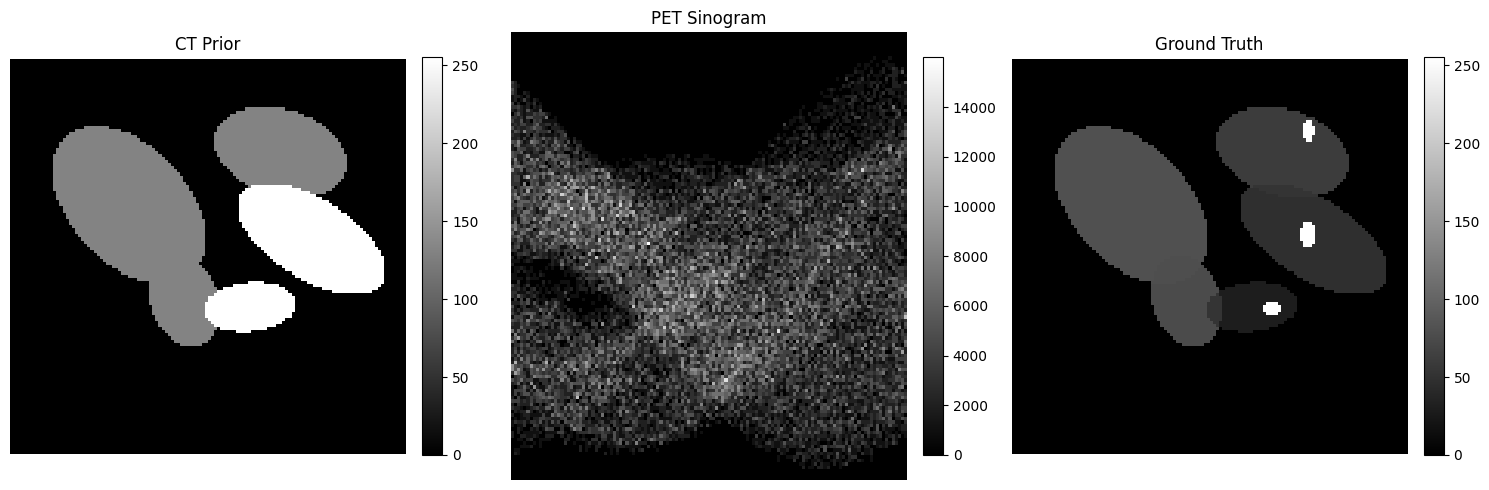

In [145]:
# Default values for reconstruction
kernel_size = 5  # Example kernel size for KEM
num_iterations = 10  # Total iterations for the KEM + DIP process
dip_iterations = 100  # Number of iterations for DIP
sigma = 1.0  # Standard deviation for filtering
angles = np.linspace(0., 180., max(ct_prior.shape), endpoint=False)

pet_sinogram = generate_sinogram_2d(ground_truth, angles)
pet_sinogram = add_poisson_noise(pet_sinogram, scale=0.001) # decrease the number to increase the noise, 0.1 was extremly noisy 


# Plot CT image, PET Image and both sinograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
im1 = axes[0].imshow(ct_prior, cmap='gray')
axes[0].set_title("CT Prior")
axes[0].axis("off")
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

im2 = axes[1].imshow(pet_sinogram, cmap='gray', aspect='auto')
axes[1].set_title("PET Sinogram")
axes[1].axis("off")
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

im3 = axes[2].imshow(ground_truth, cmap='gray')
axes[2].set_title("Ground Truth")
axes[2].axis("off")
fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

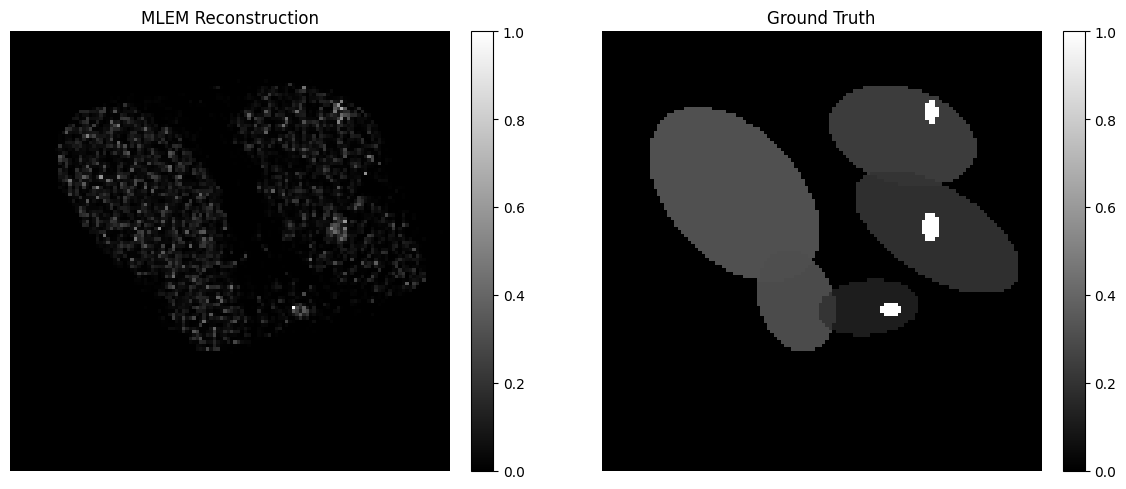

In [146]:
import matplotlib.pyplot as plt
import numpy as np

# Normalize the images to [0, 1] for better visualization
def normalize_image(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

# Example usage of the MLEM reconstruction
reconstructed, psnr_values = MLEM_reconstruction(pet_sinogram, angles, ground_truth)

# Normalize the MLEM reconstruction and ground truth for visualization
reconstructed_norm = normalize_image(reconstructed)
ground_truth_norm = normalize_image(ground_truth)

# Plot the MLEM reconstruction vs. the ground truth
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# MLEM Reconstruction Image
im1 = axes[0].imshow(reconstructed_norm, cmap='gray')
axes[0].set_title("MLEM Reconstruction")
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Ground Truth Image
im2 = axes[1].imshow(ground_truth_norm, cmap='gray')
axes[1].set_title("Ground Truth")
axes[1].axis('off')
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


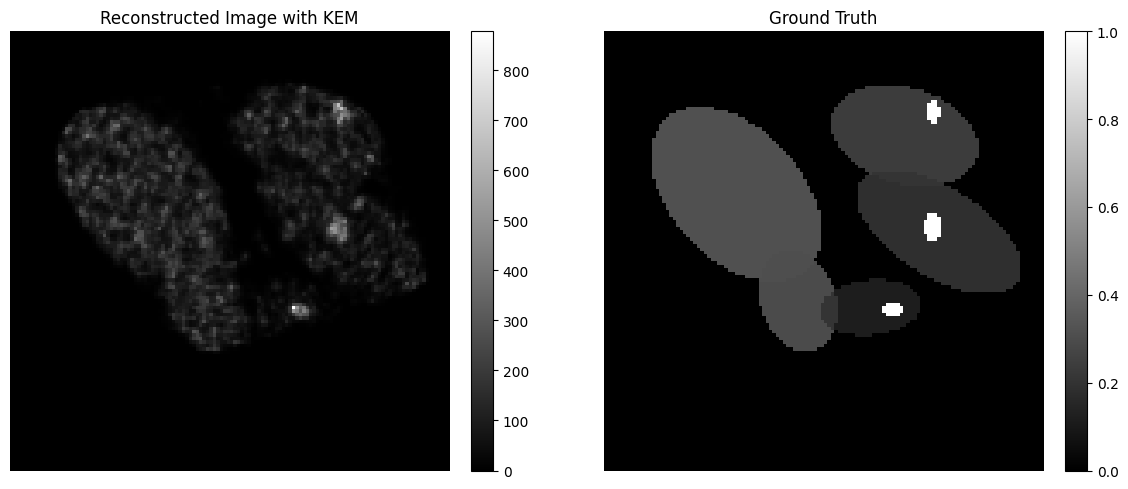

In [147]:
import matplotlib.pyplot as plt

# Example usage of KEM
fbp_initial = backproject(pet_sinogram, angles)  # FBP or some other backprojection

# Apply KEM reconstruction
kem_output = KEM_model(pet_sinogram, fbp_initial, angles, num_iterations=100)

# Ground truth for comparison
ground_truth = ground_truth_norm

# Plotting KEM reconstruction and Ground truth
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# KEM reconstruction
im1 = axes[0].imshow(kem_output, cmap='gray')
axes[0].set_title("Reconstructed Image with KEM")
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Ground truth
im2 = axes[1].imshow(ground_truth, cmap='gray')
axes[1].set_title("Ground Truth")
axes[1].axis('off')
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()



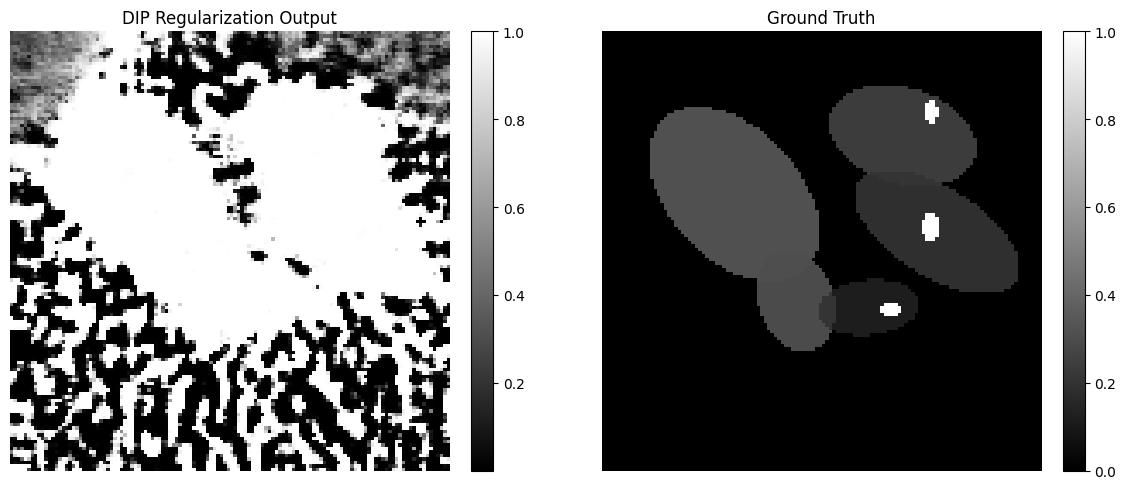

In [148]:
import matplotlib.pyplot as plt

# Example usage of DIP (assuming fbp_initial is defined)
# Apply DIP regularization on the FBP (Filtered Back Projection) output
output_image = DIP_regularization(fbp_initial, num_iterations=100)  # Adjust num_iterations as needed

# Ground truth for comparison (assuming 'pet_slice_norm' contains the ground truth image)
ground_truth = ground_truth_norm  # Replace with your actual ground truth image

# Plotting DIP regularization output and Ground truth
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create a 1x2 grid for the two images

# DIP regularization output
im1 = axes[0].imshow(output_image, cmap='gray')  
axes[0].set_title("DIP Regularization Output")  
axes[0].axis('off')  
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)  

# Ground truth
im2 = axes[1].imshow(ground_truth, cmap='gray')  
axes[1].set_title("Ground Truth")  
axes[1].axis('off')  
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)  

# Make sure the layout is tight
plt.tight_layout()  
plt.show()


In [149]:
def KEM_model_with_DIP(sinogram, initial_image, angles, sigma=0.8, num_iterations=10, apply_kernel_every=2, dip_weight=0.5):
    
    image_shape = initial_image.shape
    reconstructed = np.ones(image_shape, dtype=np.float32)  # Initialize image

    epsilon = 1e-8  # Avoid division by zero

    for i in range(num_iterations):
        # E-Step: Forward projection
        forward_projection = radon(reconstructed, theta=angles, circle=True)

        # Compute the ratio between measured and projected data
        ratio = sinogram / (forward_projection + epsilon)

        # M-Step: Backprojection of the ratio
        back_projection = iradon(ratio, theta=angles, filter_name=None, circle=True)

        # Update reconstructed image
        reconstructed *= back_projection  

        # Apply Gaussian kernel smoothing every 'apply_kernel_every' iterations
        if i % apply_kernel_every == 0 and sigma > 0:
            reconstructed = gaussian_filter(reconstructed, sigma=sigma)

        # Apply DIP regularization inside KEM iterations
        dip_output = DIP_regularization(reconstructed)  # DIP operates inside loop
        reconstructed = (1 - dip_weight) * reconstructed + dip_weight * dip_output  # Blend DIP with KEM update

        # Ensure non-negative values
        reconstructed = np.maximum(reconstructed, 0)

    return reconstructed


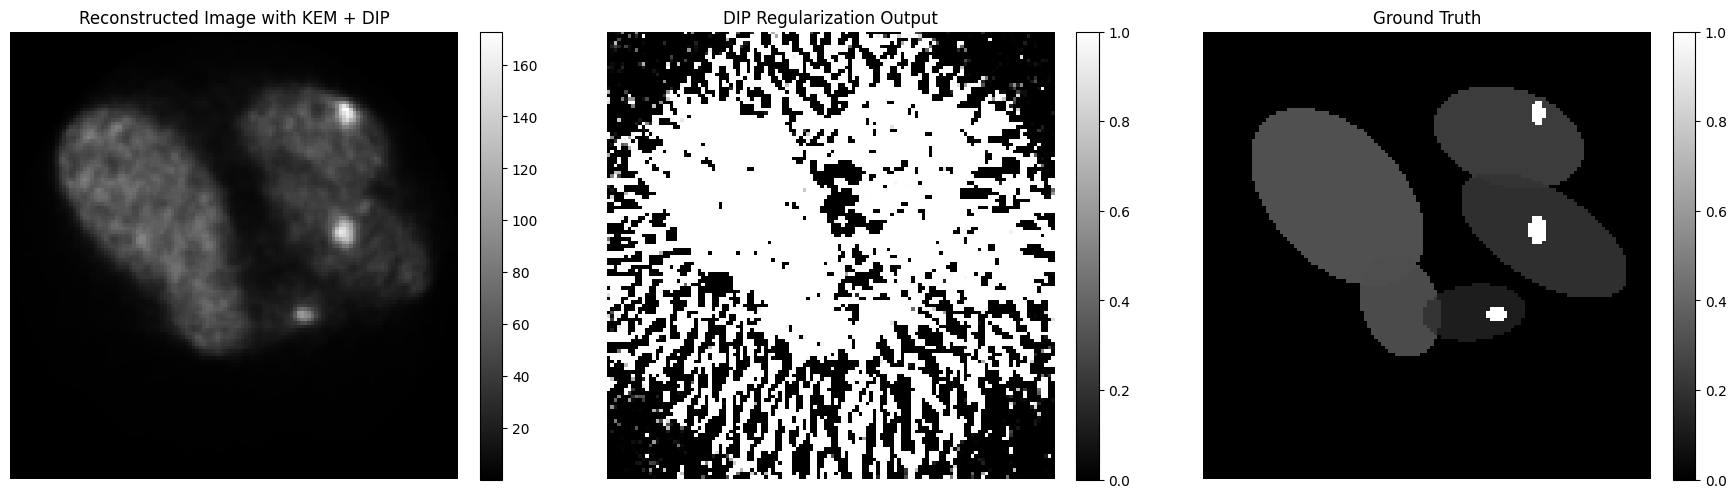

In [150]:
# Example usage of KEM and DIP
fbp_initial = backproject(pet_sinogram, angles)  # FBP or some other backprojection

# Now apply KEM with DIP regularization
image_shape = fbp_initial.shape  # Shape of the reconstructed image
#kem_output = KEM_model(pet_sinogram, fbp_initial, angles, num_iterations=10)  # Pass fbp_initial instead of image_shape
kem_dip_output = KEM_model_with_DIP(pet_sinogram, fbp_initial, angles, num_iterations=10) # change number of iterations here son we dont have KEM iterations two times, change from 10 --> 1 DID NOT WORK

# Get DIP regularization output
output_image= DIP_regularization(fbp_initial)  # Assuming DIP operates on fbp_initial

# Ground truth for comparison
ground_truth = ground_truth_norm

# Plotting KEM reconstruction, DIP output, and Ground truth
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  

# KEM reconstruction
im1 = axes[0].imshow(kem_dip_output, cmap='gray')  
axes[0].set_title("Reconstructed Image with KEM + DIP")  
axes[0].axis('off')  
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)  

# DIP regularization output
im2 = axes[1].imshow(output_image, cmap='gray')  
axes[1].set_title("DIP Regularization Output")  
axes[1].axis('off')  
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)  

# Ground truth
im3 = axes[2].imshow(ground_truth, cmap='gray')  
axes[2].set_title("Ground Truth")  
axes[2].axis('off')  
fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)  

plt.tight_layout()  
plt.show()




In [151]:
# Evaluation
def evaluate_reconstruction(ground_truth, reconstructed):
    mse_val = mse(ground_truth, reconstructed)
    rmse_val = np.sqrt(mse_val)
    psnr_val = cv2.PSNR(ground_truth.astype(np.float32), reconstructed.astype(np.float32))
    ssim_val = ssim(ground_truth, reconstructed, data_range=ground_truth.max() - ground_truth.min())

    return mse_val, psnr_val, ssim_val, rmse_val

In [156]:
metrics_kemdip = evaluate_reconstruction(ground_truth, kem_dip_output)

print("KEM + DIP Reconstruction Metrics:")
print(f"MSE: {metrics_kemdip[0]:.4f}, PSNR: {metrics_kemdip[1]:.2f}, SSIM: {metrics_kemdip[2]:.4f}, RMSE: {metrics_kemdip[3]:.4f}\n")

KEM + DIP Reconstruction Metrics:
MSE: 677.1101, PSNR: 19.82, SSIM: 0.0231, RMSE: 26.0213



In [158]:
metrics_kem = evaluate_reconstruction(ground_truth, kem_output)

print("KEM + DIP Reconstruction Metrics:")
print(f"MSE: {metrics_kem[0]:.4f}, PSNR: {metrics_kem[1]:.2f}, SSIM: {metrics_kem[2]:.4f}, RMSE: {metrics_kem[3]:.4f}\n")

KEM + DIP Reconstruction Metrics:
MSE: 4077.9541, PSNR: 12.03, SSIM: 0.4647, RMSE: 63.8589



In [159]:
metrics_mlem = evaluate_reconstruction(ground_truth_norm, reconstructed_norm)

print("KEM + DIP Reconstruction Metrics:")
print(f"MSE: {metrics_mlem[0]:.4f}, PSNR: {metrics_mlem[1]:.2f}, SSIM: {metrics_mlem[2]:.4f}, RMSE: {metrics_mlem[3]:.4f}\n")

KEM + DIP Reconstruction Metrics:
MSE: 0.0147, PSNR: 66.47, SSIM: 0.6282, RMSE: 0.1211



In [154]:
# Try other KEM + DIP model

In [155]:
# QUESTIONS

# Iterations in MLEM and KEM + DIP, fair comparison?